In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.preprocessing.sequence import skipgrams

C:\Users\neal\Anaconda3\envs\keras\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\neal\Anaconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Upload and Prep Raw Twitter Data  

In [4]:
# Upload Data 

data = pd.read_csv("../core/data/tweet_global_warming.csv", encoding="latin")
print("Full dataset: {}".format(data.shape[0]))
data['existence'].fillna(value='Ambiguous', inplace = True) #replace NA's in existence with "ambiguous"
data['existence'].replace(('Y', 'N'), ('Yes', 'No'), inplace=True) #rename so encoder doesnt get confused
data = data.dropna() #now drop NA values
print("dataset without NaN: {}".format(data.shape[0]))

data.head()

Full dataset: 6090
dataset without NaN: 6087


,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,Yes,1.0000
1,Fighting poverty and global warming in Africa ...,Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087


In [5]:
# Create Unique Encoder based on CI values 

X = data.iloc[:,0] #store tweets in X 

labels = data.iloc[:,1]
confidence_interval = data.iloc[:,2]

# encode class as integers 
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels) 

# convert integers to one hot encoded
Y_one_hot = np_utils.to_categorical(encoded_Y)


# multiply one-hot by confidence intervals
Y=[]
for i, row in enumerate(confidence_interval):
    Y.append(row*Y_one_hot[i])
Y[0:5]
Y = np.array(Y)

In [5]:
# check that you did your math right 
print (labels.head(), confidence_interval.head())
print ('Maximum confidence: ', max(confidence_interval), 'Minimum confidence: ', min(confidence_interval))

0    Yes
1    Yes
2    Yes
3    Yes
4    Yes
Name: existence, dtype: object 0    1.0000
1    1.0000
2    0.8786
3    1.0000
4    0.8087
Name: existence.confidence, dtype: float64
Maximum confidence:  1.0 Minimum confidence:  0.3346


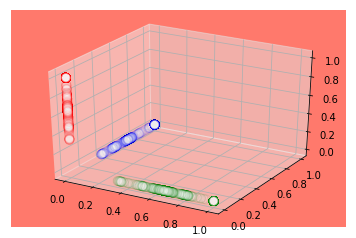

In [6]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

x = [item[0] for item in Y]
y = [item[1] for item in Y]
z = [item[2] for item in Y]
color_dict = { 'Yes':'red', 'No':'blue', 'Ambiguous':'green'}

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, edgecolors=[color_dict[i] for i in labels], s=80, alpha=0.05, facecolors='white')
ax.set_facecolor('xkcd:salmon')
plt.show()

# Implement Pretrained Word2Vec

In [6]:
# load in googles pretrained model 
google = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [7]:
# save word vectors and delete models 

vocab = google.vocab.keys()
total_vocab = len(vocab)
print ("Set includes", total_vocab, "words")
X_vecs = google.wv
del google

Set includes 3000000 words


C:\Users\neal\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [8]:
def read_data(data_file):
    for i, line in enumerate (data_file): 
        # do some pre-processing and return a list of words for each review text
        yield gensim.utils.simple_preprocess (line)

tweet_vocab = list(read_data(data['tweet']))

# CNN 

In [9]:
# # Create train and test sets
# # Generate random indexes

# test_split = 0.8
# train_size = int(len(X)*test_split)
# test_size = len(X) - train_size
vector_size = 300
window_size = 10
max_tweet_length=28

# indexes = set(np.random.choice(len(tweet_vocab), train_size + test_size, replace=False))

# X_train = np.zeros((train_size, max_tweet_length, vector_size))
# Y_train = np.zeros((train_size, 3), dtype=np.float32)
# X_test = np.zeros((test_size, max_tweet_length, vector_size))
# Y_test = np.zeros((test_size, 3), dtype=np.float32)

In [16]:
# print(type(indexes))/\
# print(tweet_vocab[:10])
print(X_vecs[tweet_vocab[0][0]].shape)
print(X_train.shape)
# # print(X_train[0])
# largest = 0
# for i in tweet_vocab:
#     if len(i) > largest:
#         largest = len(i)
# print(largest)
# print(Y[:10])
# print(len(Y))
# print(indexes)

(300,)


NameError: name 'X_train' is not defined

In [10]:
# create a single array of processed data
XX = np.zeros((len(X),max_tweet_length, vector_size))
for i in range(XX.shape[0]):
    for j, twit in enumerate(tweet_vocab[i]):
        if twit not in X_vecs:
            continue
        XX[i,j,:] = X_vecs[twit]
# print(XX[:-10,:,:])
        
# print(XX.shape)




inds = np.arange(XX.shape[0])
np.random.shuffle(inds)
# print(inds)
train = list(inds[:X.shape[0]*3//4])
test = list(inds[X.shape[0]*3//4:])
X_train = XX[train]
X_train = X_train.reshape(*X_train.shape,1)
X_test = XX[test]
X_test = X_test.reshape(*X_test.shape,1)
Y_train = Y[train]
# Y_train = Y_train.reshape(*Y_train.shape,1)
Y_test = Y[test]
# Y_test = Y_test.reshape(*Y_test.shape,1)


In [141]:
# print(X_test.reshape(*X_test.shape,1).shape)
l1 = [1,2,3]
print(l1)
print(*l1)
def myfunc(a,b,c):
    return "hi"
myfunc(*l1)

[1, 2, 3]
1 2 3


'hi'

In [105]:
# for i, index in enumerate(indexes):
#     for t, token in enumerate(tweet_vocab[index]):
#         if t >= max_tweet_length:
#             break
        
#         if token not in X_vecs:
#             continue
    
#         if i < train_size:
#             X_train[i, t, :] = X_vecs[token]
#         else:
#             X_test[i - train_size, t, :] = X_vecs[token]
            
            
#         if i < train_size:
#             Y_train[i, :] = Y[index]
#         else:
#             Y_test[i - train_size, :] = Y[index]

In [29]:
# load up sentiment data from stanford
cols = ['sentiment','id','date','query_string','user','text']
data = pd.read_csv("../trainingandtestdata/training.1600000.processed.noemoticon.csv",header=None, names=cols, encoding = "ISO-8859-1")

In [33]:
# data.sentiment.count()
data['sentiment'] = (data['sentiment']-2)//2
data.head()

,sentiment,id,date,query_string,user,text
0,-1,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,-1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,-1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,-1,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,-1,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [58]:
# pre_x = np.zeros((len(data),28,300)).astype(np.float32)
# print(pre_x.shape)
def shuffle(n):
    inds = np.random.randint(0,len(data),n)
    out = np.zeros((len(inds), 28, 300)).astype(np.float32)
    for i, ind in enumerate(inds):
        text = data['text'][ind].split(" ")
        for j, word in enumerate(text):
            if word not in X_vecs:
                continue
            if j > 27:
                continue
            out[i,j,:] = X_vecs[twit]
    Y=[]
    for i in np.array(data['sentiment'][inds]):
        Y.append(Y_one_hot[i])
    Y = np.array(Y)
    return [out.astype(np.float32).reshape(*out.shape,1), Y.astype(np.int32)]
x, y = shuffle(10000)
print(y.shape)
# print(x)
# for i in range(len(data)):
#     pre_x[i] = 

(10000, 3)


In [ ]:
#Some variables 
from keras.layers import Dropout, Convolution2D, MaxPooling2D

top_words = 1000
max_words = 150
filters = 32 #filter = 1 x KERNEL 

inpurt_shape = (X_train.shape[1:])
print(inpurt_shape)
# create the model 
model = Sequential()

model.add(Convolution2D(32, kernel_size=9, activation='elu', padding='same',
                 input_shape=inpurt_shape))
model.add(MaxPooling2D(pool_size=5))
model.add(Convolution2D(filters=64, kernel_size=9, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(filters=64, kernel_size=9, padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(filters=filters, kernel_size=9, padding='same', activation='elu'))
model.add(Flatten())
model.add(Dense(250, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='linear')) #change from logistic 
model.compile(loss='mse', optimizer='adam', metrics=['accuracy','mse']) 
print(model.summary())

# Fit the model
for i in range(100):
    x, y = shuffle(10000)
    model.fit(x, 
              y, 
              validation_data=(X_test, Y_test), 
              epochs=(i+1)*20, 
              initial_epoch = i*20,
              batch_size=128,
              verbose=1)

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

(28, 300, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 28, 300, 32)       2624      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 5, 60, 32)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 5, 60, 64)         165952    
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 2, 30, 64)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 2, 30, 64)         331840    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 1, 15, 64)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 1, 15, 32)         165920  

In [64]:
pred = model.predict(X_test)
print(Y_test[:100], pred[:10])

[[0.     0.479  0.    ]
 [0.     0.     1.    ]
 [0.6683 0.     0.    ]
 [0.     0.     1.    ]
 [0.     0.     0.7114]
 [0.6564 0.     0.    ]
 [0.     0.     0.6679]
 [0.     0.6605 0.    ]
 [0.6727 0.     0.    ]
 [0.     0.     1.    ]
 [0.6921 0.     0.    ]
 [0.     0.     1.    ]
 [0.     0.     0.665 ]
 [0.6015 0.     0.    ]
 [0.     0.     0.6105]
 [1.     0.     0.    ]
 [0.     0.6658 0.    ]
 [0.     0.     1.    ]
 [0.     0.     0.6718]
 [0.     0.     0.5534]
 [1.     0.     0.    ]
 [0.8239 0.     0.    ]
 [0.     1.     0.    ]
 [0.     0.     1.    ]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [0.     0.     1.    ]
 [0.     0.     0.6611]
 [0.     0.     1.    ]
 [0.     0.     1.    ]
 [0.     0.6621 0.    ]
 [0.6512 0.     0.    ]
 [0.     0.6485 0.    ]
 [0.     0.     1.    ]
 [0.6843 0.     0.    ]
 [0.     0.     1.    ]
 [0.     0.     0.5127]
 [0.     0.     1.    ]
 [0.     0.681  0.    ]
 [0.     0.     0.6546]
 [0.     0.7333 

In [15]:
import keras
keras.metrics.categorical_accuracy()

<module 'keras.metrics' from '//anaconda/lib/python3.5/site-packages/keras/metrics.py'>